## GOAL: Implementation of Given Article and Adding Additional Feature with Latent Factor

**Bibtext**<br>
@article{ 
  
  xie2015link, <br>
  title={A link prediction approach for item recommendation with complex number},<br>
  author={Xie, Feng and Chen, Zhen and Shang, Jiaxing and Feng, Xiaoping and Li, Jun},<br>
  journal={Knowledge-Based Systems},<br>
  volume={81},<br>
  pages={148--158},<br>
  year={2015},<br>
  publisher={Elsevier}<br>
}


## Configurations

### GPU

Don't forget to choose change runtime to GPU from **_Runtime > Change Runtime type_**

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### Mounting Google Drive

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialization

### Importing Numpy, Pandas


In [0]:
import numpy  as np
import pandas as pd

### Reading MovieLens Dataset

[About MovieLens 100K](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt)<br>
[Reference](http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/)

In [130]:
dataset_drive_path = 'drive/My Drive/Colab Notebooks/Recommender_Final_Project/dataset/ml-100k/u.data'

columns     = ['userId','movieId','rating','timestamp']
df_ratings = pd.read_csv(dataset_drive_path, 
                         sep='\t', 
                         error_bad_lines=False, 
                         names=columns, 
                         low_memory=False,  
                         encoding="latin-1" )

df_ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [131]:
number_of_users = df_ratings.userId.unique().size
number_of_items  = df_ratings.movieId.unique().size

print("There are {} users.".format(number_of_users)) 
print("There are {} movies.".format(number_of_items))

There are 943 users.
There are 1682 movies.


### Spliting Dataset as Train and Test

According to article;


1.   Get %10 of items rated by each user call it temporary test set
2.   Filter out ratings equals 5 from temporary test and call it final test set
3.   Remove final test items from ratings and call it train set 




In [132]:
from sklearn.model_selection import train_test_split
df_final_train, df_temporary_test  = train_test_split(df_ratings, test_size=0.1, random_state=42)
df_final_test      = df_temporary_test.loc[df_temporary_test['rating']==5]
df_final_test.head()

,userId,movieId,rating,timestamp
84004,598,286,5,886711452
14888,276,408,5,874786467
94892,933,180,5,874854723
29130,416,156,5,893212895
11405,165,651,5,879525961


In [133]:
df_temporary_test  = df_ratings.sample(frac=0.1, random_state=1)
df_final_test      = df_temporary_test.loc[df_temporary_test['rating']==5]
df_final_test.head()

,userId,movieId,rating,timestamp
43660,508,185,5,883777430
87278,518,742,5,876823804
14317,178,28,5,882826806
9507,271,192,5,885848373
91216,787,313,5,888979547


In [134]:
df_final_train   = df_ratings.drop(df_final_test.index)
df_final_train.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [135]:
print("Size of final test set is  :", df_final_test.shape)
print("Size of final train set is :", df_final_train.shape)

Size of final test set is  : (2162, 4)
Size of final train set is : (97838, 4)


### Creating User-Item Matrix From Final Train Set

In [136]:
df_user_item = df_final_train.pivot(index='userId', 
                                    columns='movieId', 
                                    values='rating').fillna(0)
df_user_item.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating Sparsity 

According to article sparsity calculated by given formula;

sparsity level = 1  - #rating entries / #total entries



In [137]:
ui = np.array(df_user_item)

rating_entries = (ui != 0).sum()
total_entries  = (ui >= 0).sum()

print("Sparsity Level:  {:.2f}% ".format(( 1 - ( rating_entries / total_entries )) * 100 ))

Sparsity Level:  93.83% 


## CORLP Implementation Mentioned In The Article 

### Creating Aui Matrix

In [0]:
threshold = 3

In [139]:
df_Aui = df_user_item.copy()
df_Aui.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Converting Aui Matrix to Corresponding Complex Number

[  **j** ] --> if user likes item or item dislikes user<br>
[**-j** ] --> if user dislikes item or item likes user

In [0]:
df_Aui[(0 < df_user_item) & (df_user_item < threshold)] = -1j
df_Aui[ df_user_item >= threshold ] = 1j

In [141]:
df_Aui.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,1j,1j,1j,1j,1j,1j,1j,(-0-1j),1j,1j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
2,1j,0j,0j,0j,0j,0j,0j,0j,0j,(-0-1j),...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
3,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
4,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
5,1j,1j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j


### Creating A Matrix (Auu, Aui, Aii, Aiu)

In [142]:
Aui = np.array(df_Aui)
Aiu = (Aui.T) * -1

print("Shape of Aui:", Aui.shape)
print("Shape of Aiu:", Aiu.shape)

Shape of Aui: (943, 1682)
Shape of Aiu: (1682, 943)


In [143]:
num_user = Aui.shape[0] # 943
num_item = Aui.shape[1] # 1681

Auu = np.zeros((num_user, num_user), dtype=complex)
Aii = np.zeros((num_item, num_item), dtype=complex)

print("Shape of Auu:", Auu.shape)
print("Shape of Aii:", Aii.shape)

Shape of Auu: (943, 943)
Shape of Aii: (1682, 1682)


In [144]:
A = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

print("\t       Shape of A", A.shape)
print("\n\t\t\tA\n" + '-'*55 + "\n" ,A)

	       Shape of A (2625, 2625)

			A
-------------------------------------------------------
 [[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]


### Calculating A<sup>3</sup>,	A<sup>5</sup>, A<sup>7</sup>, A<sup>9</sup>

In [0]:
from numpy.linalg import matrix_power

In [0]:
def calculate_matrix_power_of (A):
  ''' 
  Calculates A^3, A^5, A^7 ,A^9
  
  Parameters 
  ----------
  A: numpy array -->  A matrix mentioned in article
    
  Returns
  ----------
  
  list of calculation
  
  '''
  powers_of_A = []
  for power in  range(3,10,2):
    powers_of_A.append( matrix_power(A, power) )
    
    print("\n\t       Shape of A^{} {}".format(power,powers_of_A[-1].shape))
    print("\n\t\t\tA^{}\n\t\t{}\n{}".format(power, '-' * 20, powers_of_A[-1]))
  
  return powers_of_A
  
  

In [147]:
powers_of_A = calculate_matrix_power_of(A)


	       Shape of A^3 (2625, 2625)

			A^3
		--------------------
[[0.  +0.j 0.  +0.j 0.  +0.j ... 0.  -5.j 0. +78.j 0.+112.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0. -11.j 0.  +8.j 0.  +9.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +4.j 0.  -2.j 0.  +3.j]
 ...
 [0.  +5.j 0. +11.j 0.  -4.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0. -78.j 0.  -8.j 0.  +2.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.-112.j 0.  -9.j 0.  -3.j ... 0.  +0.j 0.  +0.j 0.  +0.j]]

	       Shape of A^5 (2625, 2625)

			A^5
		--------------------
[[0.+0.000000e+00j 0.+0.000000e+00j 0.+0.000000e+00j ... 0.-1.336690e+05j
  0.+1.090283e+06j 0.+1.495375e+06j]
 [0.+0.000000e+00j 0.+0.000000e+00j 0.+0.000000e+00j ... 0.-5.483500e+04j
  0.+2.145810e+05j 0.+2.935260e+05j]
 [0.+0.000000e+00j 0.+0.000000e+00j 0.+0.000000e+00j ... 0.+1.482000e+03j
  0.+5.088000e+03j 0.+1.208100e+04j]
 ...
 [0.+1.336690e+05j 0.+5.483500e+04j 0.-1.482000e+03j ... 0.+0.000000e+00j
  0.+0.000000e+00j 0.+0.000000e+00j]
 [0.-1.090283e+06j 0.-2.145810e+05j 0.-5.088000

### Testing Recommender  System - Calculating Hits rate and Coverage  of A<sup>3</sup>,	A<sup>5</sup>, A<sup>7</sup>, A<sup>9</sup>


In [0]:
def test_recommender_system(A, N):
  """
  Calculates hits rate and coverage.
  
  Parameters
  ----------
  A: is numpy array. In our case, A3, A5, A7, A9
  N: is an integer. Number of items which will be recommended.
  
  Returns
  -------
  hit_rate: float
  coverage: float
  """

  # get trained user item matrix part from A.
  trained_Aui = A[0: number_of_users,
                 number_of_users:A.shape[1]]
  
  # sort predictions by descending order.
  indexes = (-trained_Aui).argsort(axis=1)
  
  
  rec = {}
  for u in range(0, number_of_users):
    mask   = np.isin(indexes[u],unrated_movie_indexes[u])
    rec[u] = indexes[u][mask]
   
  # get N recommendable item for each user.
  
  recommended_item_indexes = np.zeros((number_of_users, N), dtype=int)
  for u in range(0, number_of_users):
    row = rec[u][:N]
    recommended_item_indexes[u] = row
  
  # find movieId of N recommandable items.
  recommended_movie_id = df_user_item.columns[recommended_item_indexes]

  # calculate hit_rate and coverage
  hit = 0
  for user_id, movie_ids in enumerate(recommended_movie_id):
    
    mask_user  = df_final_test['userId'].isin([(user_id+1)])
    mask_movie = df_final_test['movieId'].isin(movie_ids)    
    hit += df_final_test[mask_user & mask_movie]['movieId'].count()
 

  hit_rate = hit / len(df_final_test.index)
  coverage = len(np.unique(recommended_movie_id)) / number_of_items
  
  return (hit_rate, coverage)
  

In [151]:

unrated_movie_indexes = np.where(df_user_item==0)
arr = np.array(unrated_movie_indexes)
arr.shape

(2, 1488288)

In [0]:
unrated_movie_indexes = {}
for A, B in zip(arr[0], arr[1]):
  if A in unrated_movie_indexes:
    unrated_movie_indexes[A].append(B)
  else:
    unrated_movie_indexes[A] = [B]
    

In [153]:
from tqdm import tqdm

test_results = {}

# [ 10  20  30  40  50  60  70  80  90 100]
number_of_recommended_item = np.arange(10, 110, 10) 

power = 3
for A in tqdm(powers_of_A):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(A, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
      
  power += 2

100%|██████████| 4/4 [01:07<00:00, 16.94s/it]


In [154]:
test_results

{3: [(0.24838112858464384, 0.12009512485136742),
  (0.3445883441258094, 0.1896551724137931),
  (0.41720629047178537, 0.24494649227110582),
  (0.4690101757631822, 0.2919143876337693),
  (0.5143385753931545, 0.34185493460166466),
  (0.5550416281221091, 0.38525564803804996),
  (0.5832562442183163, 0.4286563614744352),
  (0.6119333950046254, 0.4643281807372176),
  (0.6369102682701202, 0.4976218787158145),
  (0.6604995374653099, 0.5315101070154578)],
 5: [(0.1956521739130435, 0.07431629013079667),
  (0.2835337650323774, 0.1159334126040428),
  (0.3418131359851989, 0.15636147443519618),
  (0.3908418131359852, 0.18846611177170036),
  (0.44033302497687327, 0.21938168846611178),
  (0.4805735430157262, 0.24613555291319858),
  (0.5180388529139686, 0.27110582639714625),
  (0.545790934320074, 0.2966706302021403),
  (0.5698427382053654, 0.3192627824019025),
  (0.6022201665124884, 0.34661117717003564)],
 7: [(0.19287696577243293, 0.07193816884661118),
  (0.2742830712303423, 0.11058263971462545),
  (0.

### Ploting Hits Rate and  Coverage Given Length

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

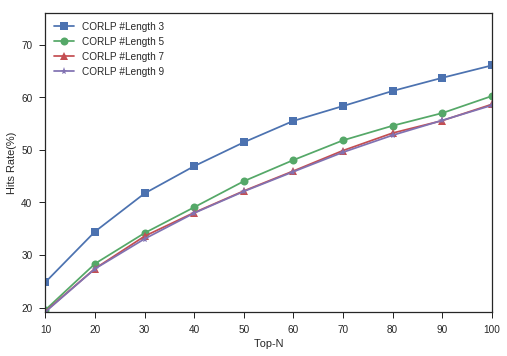

In [156]:
sns.set(style="ticks")

x = np.arange(10, 110, 10) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = []
for key, value in test_results.items():
    [y.append(hit_rate[0]*100) for hit_rate in value]

fig, ax = plt.subplots()
ax.plot(x, 
        y[:10],
        marker='s', 
        markersize=8,
        label='CORLP #Length 3')

ax.plot(x, 
        y[10:20],
        marker='o', 
        markersize=8,
        label='CORLP #Length 5')

ax.plot(x, 
        y[20:30],
        marker='^', 
        markersize=8,
        label='CORLP #Length 7')

ax.plot(x,
        y[30:],
        marker='*', 
        markersize=8,
        label='CORLP #Length 9')

plt.xlabel("Top-N")
plt.ylabel("Hits Rate(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(y), max(y)+10)

leg = ax.legend(loc='upper left')
#fig.savefig('drive/My Drive/Colab Notebooks/Recommender_Final_Project/plots/' + 'corlp_hits_rate'+'.png')


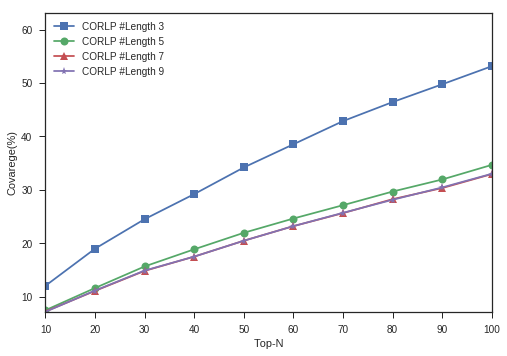

In [157]:
import seaborn as sns
sns.set(style="ticks")

x = np.arange(10, 110, 10) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = []
for key, value in test_results.items():
    [y.append(coverage[1]*100) for coverage in value]

fig, ax = plt.subplots()
ax.plot(x, 
        y[:10],
        marker='s', 
        markersize=8,
        label='CORLP #Length 3')

ax.plot(x, 
        y[10:20],
        marker='o', 
        markersize=8,
        label='CORLP #Length 5')

ax.plot(x, 
        y[20:30],
        marker='^', 
        markersize=8,
        label='CORLP #Length 7')

ax.plot(x,
        y[30:],
        marker='*', 
        markersize=8,
        label='CORLP #Length 9')

plt.xlabel("Top-N")
plt.ylabel("Covarege(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(y), max(y)+10)

leg = ax.legend(loc='upper left')
#fig.savefig('drive/My Drive/Colab Notebooks/Recommender_Final_Project/plots/' + 'corlp_coverage_rate'+'.png')

## Additional improvement - Latent Factor

In [158]:
!pip install surprise

In [0]:
from surprise import Reader, Dataset, SVD


### Estimating Latent Factors of Train set

In [166]:
reader = Reader()

data = Dataset.load_from_df(df_final_train[['userId', 'movieId', 'rating']], reader)

train_set = data.build_full_trainset()

svd = SVD(n_factors=5)

trained_data = svd.fit(train_set)

pu = trained_data.pu
qi = trained_data.qi

print('PU --> {}\n\n{}\n'.format(pu.shape, pu))
print('QI --> {}\n\n{}'.format(qi.shape, qi))

PU --> (943, 5)

[[ 0.07629614 -0.03194175 -0.0229084   0.01914841 -0.04526571]
 [-0.10145385  0.21154202  0.26781031 -0.12116553 -0.03483506]
 [-0.24678373 -0.30852838 -0.15810689 -0.20409696  0.15862411]
 ...
 [ 0.23056734 -0.08538645 -0.27887689 -0.15816084 -0.13048077]
 [-0.15593226 -0.0733772   0.01625791 -0.10658711  0.12507994]
 [-0.00472378  0.1240166  -0.06098533 -0.19331266  0.18182425]]

QI --> (1682, 5)

[[-0.09635773 -0.1348708   0.1073533   0.0023216  -0.31297006]
 [-0.20951897 -0.3128191  -0.46199943  0.24330811 -0.07533899]
 [ 0.07578951  0.08315862  0.15338365 -0.11414247 -0.19044044]
 ...
 [ 0.03858808 -0.05781842  0.03197151 -0.10116284  0.0961027 ]
 [ 0.01446107 -0.04995575  0.18258793 -0.07335991  0.00537243]
 [ 0.05563046  0.04675043  0.19641589 -0.09406932 -0.05105424]]


### Finding Similarities Between Users and Items 

In [0]:
cos_threshold = 0.5

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

pu_similarities = cosine_similarity(pu)

pu_similarities[pu_similarities >= cos_threshold] =  1
pu_similarities[pu_similarities <  cos_threshold] = -1

Auu = pu_similarities

print(pu_similarities)

[[ 1. -1. -1. ...  1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]
 ...
 [ 1. -1. -1. ...  1. -1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]]


In [169]:
qi_similarities = cosine_similarity(qi)


qi_similarities[qi_similarities >= cos_threshold] =  1
qi_similarities[qi_similarities <  cos_threshold] = -1

Aii = qi_similarities

print(Aii, Aii.shape)

[[ 1. -1.  1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 [ 1. -1.  1. ... -1.  1.  1.]
 ...
 [-1. -1. -1. ...  1.  1. -1.]
 [-1. -1.  1. ...  1.  1.  1.]
 [-1. -1.  1. ... -1.  1.  1.]] (1682, 1682)


In [170]:
B = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

print("\t       Shape of B", B.shape)
print("\n\t\t\tB\n" + '-'*55 + "\n" ,B)

	       Shape of B (2625, 2625)

			B
-------------------------------------------------------
 [[ 1.+0.j -1.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  1.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j -1.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [-0.+0.j -0.+0.j -0.+0.j ...  1.+0.j  1.+0.j -1.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ...  1.+0.j  1.+0.j  1.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j ... -1.+0.j  1.+0.j  1.+0.j]]


### Calculating B<sup>3</sup>, B<sup>5</sup>, B<sup>7</sup>, B<sup>9</sup>

In [171]:
powers_of_B = calculate_matrix_power_of(B)


	       Shape of A^3 (2625, 2625)

			A^3
		--------------------
[[-297759.     +0.j -346422.     +0.j -317587.     +0.j ...
        0.+157212.j       0.+154455.j       0.+158371.j]
 [-346422.     +0.j -252057.     +0.j -298720.     +0.j ...
        0. +69006.j       0. +67021.j       0. +70108.j]
 [-317587.     +0.j -298720.     +0.j -191990.     +0.j ...
        0. +32873.j       0. +31865.j       0. +33828.j]
 ...
 [      0.-157212.j       0. -69006.j       0. -32873.j ...
  -763823.     +0.j -830809.     +0.j -895006.     +0.j]
 [      0.-154455.j       0. -67021.j       0. -31865.j ...
  -830809.     +0.j -693503.     +0.j -748668.     +0.j]
 [      0.-158371.j       0. -70108.j       0. -33828.j ...
  -895006.     +0.j -748668.     +0.j -740617.     +0.j]]

	       Shape of A^5 (2625, 2625)

			A^5
		--------------------
[[-1.87549014e+11+0.00000000e+00j -1.61078426e+11+0.00000000e+00j
  -1.40970199e+11+0.00000000e+00j ...  0.00000000e+00+2.48995710e+11j
   0.00000000e+00+2.4367

### Testing Recommender  System - Calculating Hits rate and Coverage  of B<sup>3</sup>,	B<sup>5</sup>, B<sup>7</sup>, B<sup>9</sup>


In [172]:
test_results = {}

# [ 10  20  30  40  50  60  70  80  90 100]
number_of_recommended_item = np.arange(10, 110, 10) 

power = 3
for B in tqdm(powers_of_B):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(B, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
      
  power += 2

100%|██████████| 4/4 [01:08<00:00, 17.06s/it]


In [173]:
test_results

{3: [(0.16790009250693802, 0.0535077288941736),
  (0.272895467160037, 0.08799048751486326),
  (0.34551341350601295, 0.11712247324613555),
  (0.393154486586494, 0.13793103448275862),
  (0.4477335800185014, 0.15517241379310345),
  (0.4856614246068455, 0.1759809750297265),
  (0.5185013876040703, 0.1938168846611177),
  (0.5434782608695652, 0.21521997621878716),
  (0.5707678075855689, 0.23067776456599287),
  (0.5989824236817761, 0.25326991676575505)],
 5: [(0.16419981498612396, 0.06064209274673008),
  (0.2567067530064755, 0.09274673008323424),
  (0.32053654024051803, 0.12009512485136742),
  (0.38020351526364476, 0.1492271105826397),
  (0.4181313598519889, 0.16884661117717004),
  (0.4597594819611471, 0.19143876337693222),
  (0.49167437557816834, 0.2140309155766944),
  (0.5143385753931545, 0.2342449464922711),
  (0.5351526364477336, 0.2562425683709869),
  (0.5513413506012951, 0.27586206896551724)],
 7: [(0.12858464384828863, 0.054696789536266346),
  (0.20027752081406106, 0.08977407847800238),

### Plotting Hits Rate and Coverage 

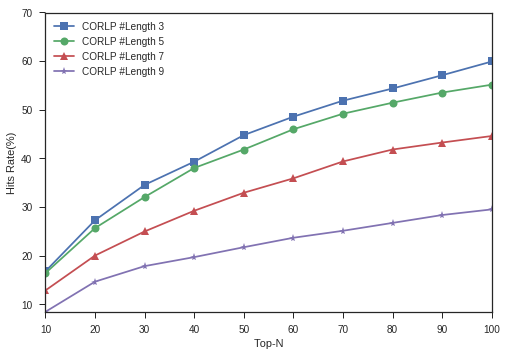

In [174]:
sns.set(style="ticks")

x = np.arange(10, 110, 10) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = []
for key, value in test_results.items():
    [y.append(hit_rate[0]*100) for hit_rate in value]

fig, ax = plt.subplots()
ax.plot(x, 
        y[:10],
        marker='s', 
        markersize=8,
        label='CORLP #Length 3')

ax.plot(x, 
        y[10:20],
        marker='o', 
        markersize=8,
        label='CORLP #Length 5')

ax.plot(x, 
        y[20:30],
        marker='^', 
        markersize=8,
        label='CORLP #Length 7')

ax.plot(x,
        y[30:],
        marker='*', 
        markersize=8,
        label='CORLP #Length 9')

plt.xlabel("Top-N")
plt.ylabel("Hits Rate(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(y), max(y)+10)

leg = ax.legend(loc='upper left')
#fig.savefig('drive/My Drive/Colab Notebooks/Recommender_Final_Project/plots/' + 'latent_hits_rate'+'.png')

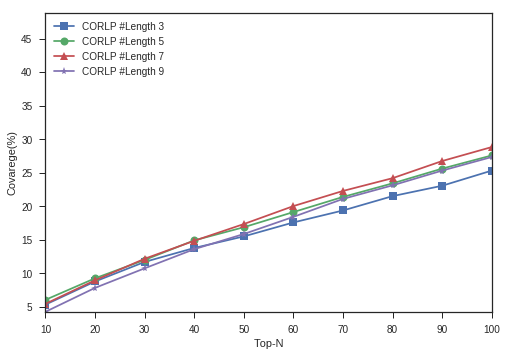

In [175]:
sns.set(style="ticks")

x = np.arange(10, 110, 10) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = []
for key, value in test_results.items():
    [y.append(coverage[1]*100) for coverage in value]

fig, ax = plt.subplots()
ax.plot(x, 
        y[:10],
        marker='s', 
        markersize=8,
        label='CORLP #Length 3')

ax.plot(x, 
        y[10:20],
        marker='o', 
        markersize=8,
        label='CORLP #Length 5')

ax.plot(x, 
        y[20:30],
        marker='^', 
        markersize=8,
        label='CORLP #Length 7')

ax.plot(x,
        y[30:],
        marker='*', 
        markersize=8,
        label='CORLP #Length 9')

plt.xlabel("Top-N")
plt.ylabel("Covarege(%)")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(min(y), max(y)+20)

leg = ax.legend(loc='upper left')
#fig.savefig('drive/My Drive/Colab Notebooks/Recommender_Final_Project/plots/' + 'latent_coverage'+'.png')